# Projekt ML: Predykcja Popularności Utworów Spotify
## Etap 4: Strojenie Hiperparametrów
**Autor:** Grzegorz Zioło

W tym notatniku skupiam się na optymalizacji wybranego wcześniej modelu – XGBoost.
Użyje techniki Randomized Search Cross Validation, aby znaleźć najlepszą kombinację parametrów.

**Cele:**
1. Przetestowanie różnych głębokości drzew, szybkości uczenia i metod regularyzacji.
2. Wizualizacja wpływu parametrów na błąd (RMSE).
3. Wybór najlepszego zestawu parametrów dla modelu.

Sprawdzę, czy przyjęte uprzednio parametry (`max_depth=8`, `eta=0.05`, `subsample=0.8`) są optymalne, czy może jest możliwe wylosowanie parametrów, które pozwolą uzyskać jeszcze wyższe $R^2$.

In [28]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

sys.path.append(os.path.abspath('..'))

from src.loaders import DataLoaderFactory
from src.cleaners import SpotifyDataCleaner
from src.preprocessors import SpotifyPipelinePreprocessor

### 1. Przygotowanie Danych
Ładujemy dane tak samo jak w poprzednich krokach.

In [3]:
# Ładowanie i czyszczenie
loader = DataLoaderFactory.get_loader("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
cleaner = SpotifyDataCleaner()
df_clean = cleaner.clean(loader.load())

# Preprocessing
preprocessor = SpotifyPipelinePreprocessor(target_col='popularity', test_size=0.2)
X_train, X_test, y_train, y_test = preprocessor.process(df_clean)

print(f"Dane gotowe. X_train: {X_train.shape}")

Dane gotowe. X_train: (71792, 127)


### 2. Konfiguracja Przestrzeni Poszukiwań (Search Space)
Definiuje 5 najważniejszych parametrów:
* `max_depth` - jak skomplikowane mogą być drzewa (głębsze = łapią więcej niuansów, ale też szum).
* `learning_rate` - jak szybko model się uczy (mniejsze wartości wymagają więcej drzew).
* `n_estimators` - liczba drzew (więcej = lepiej, ale wolniej i rośnie ryzyko overfittingu).
* `subsample` - jaki procent danych widzi każde drzewo (losowość zapobiega overfittingowi).
* `colsample_bytree` - jaki ułamek kolumn (cech) jest losowany do budowy każdego pojedynczego drzewa.
* `min_child_weight` - konserwatyzm modelu (im wyższe, tym trudniej modelowi stworzyć nowy liść).
* `gamma` - minimalna redukcja straty wymagana do podziału liścia.

In [17]:
# Definicja siatki parametrów do wylosowania
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [500, 800, 1000, 1500],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

# Inicjalizacja modelu bazowego
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

# Konfiguracja RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,  # Liczba prób
    scoring='neg_root_mean_squared_error',  # Optymalizacja pod RMSE
    cv=5,  # 5-krotna walidacja krzyżowa
    verbose=1,
    n_jobs=1,
    random_state=42
)

### 3. Uruchomienie Strojenia (Tuning)
To potrwa chwilę (od kilku do kilkunastu minut w zależności od sprzętu).

In [18]:
%%time
print("Rozpoczynanie szukania najlepszych parametrów...")
random_search.fit(X_train, y_train)

print(f"Najlepszy wynik (RMSE): {-random_search.best_score_:.4f}")
print("Najlepsze parametry:")
print(random_search.best_params_)

Rozpoczynanie szukania najlepszych parametrów...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Najlepszy wynik (RMSE): 15.3155
Najlepsze parametry:
{'subsample': 0.8, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.9}
CPU times: total: 2h 38min 27s
Wall time: 11min 26s


### 4. Analiza Wyników
Zobaczmy jak zmieniały się wyniki w zależności od parametrów. Pozwoli to zrozumieć naturę problemu np. czy głębsze drzewa zawsze są lepsze?.

In [23]:
# Przygotowanie danych (wyników)

# Wyciągamy wyniki do DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Wybieramy interesujące kolumny
params_cols = [f'param_{key}' for key in param_dist.keys()]
cols_to_keep = params_cols + ['mean_test_score']
analysis_df = results_df[cols_to_keep].copy()

# Zamieniamy ujemne MSE na dodatnie RMSE
analysis_df['RMSE'] = -analysis_df['mean_test_score']

# Sortujemy od najlepszego wyniku (najniższe RMSE)
display(analysis_df.sort_values(by='RMSE').head(5))

,param_max_depth,param_learning_rate,param_n_estimators,param_subsample,param_colsample_bytree,param_min_child_weight,param_gamma,mean_test_score,RMSE
6,8,0.10,800,0.8,0.9,5,0.5,-15.315490,15.315490
2,5,0.05,1500,0.8,0.8,1,0.4,-15.365609,15.365609
15,5,0.10,800,0.7,0.6,3,0.0,-15.429785,15.429785
25,6,0.10,1500,0.6,0.6,7,0.2,-15.442765,15.442765
11,8,0.03,800,0.9,0.9,3,0.2,-15.531934,15.531934


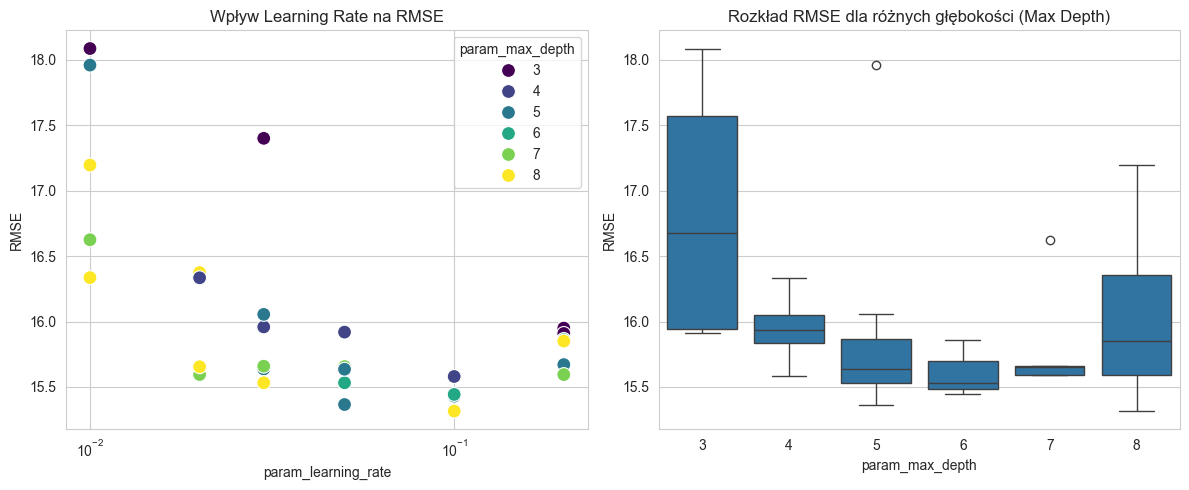

In [50]:
# Konfiguracja wykresu
plt.figure(figsize=(12, 5))

# Wykres 1: Wpływ Learning Rate na wynik
# Jaki poziom szybkości uczenia, spowoduje niedouczenie modelu, a jaki będzie optymalny?
plt.subplot(1, 2, 1)
sns.scatterplot(data=analysis_df, x='param_learning_rate', y='RMSE', hue='param_max_depth', palette='viridis', s=100)
plt.title('Wpływ Learning Rate na RMSE')
plt.xscale('log') # poprawa czytelności wykresu

# Wykres 2: Wpływ Max Depth na wynik
# Jak głębokie powinny być drzewa aby uniknąć niedouczenia lub przeuczenia modelu?
plt.subplot(1, 2, 2)
sns.boxplot(data=analysis_df, x='param_max_depth', y='RMSE')
plt.title('Rozkład RMSE dla różnych głębokości (Max Depth)')

plt.tight_layout()
plt.show()

**Wnioski z analizy wpływu `learning_rate` oraz `max_depth`**

Na podstawie powyższych wykresów możemy sformułować kluczowe rekomendacje dla ostatecznej konfiguracji modelu:

1. Wpływ Szybkości Uczenia (`learning_rate`):
    * Istnieje silna korelacja między wyższym learning_rate a niższym błędem RMSE (w badanym zakresie).
    * Przy `learning_rate` = 0.01 model jest wyraźnie niedouczony (underfitting) – błędy oscylują wokół 17-18 punktów, co jest wynikiem gorszym niż regresja liniowa.
    * Najlepsze wyniki (najniższe punkty na wykresie lewym) osiągane są w okolicy 0.1. Dalsze zwiększanie (w stronę 0.2) wydaje się już nie przynosić tak spektakularnej poprawy, a może grozić niestabilnością.

2. Wpływ Głębokości Drzewa (`max_depth`):
   * Głębokość 3-4 (Underfitting): Drzewa są zbyt proste, aby uchwycić złożoność gustów muzycznych. Błąd jest wysoki i ma duży rozrzut.
   * Głębokość 6-7 (Sweet Spot): Tutaj znajduje się optimum. Pudełka (boxplots) są najniżej położone, a ich wysokość (rozstęp ćwiartkowy) jest stosunkowo mała, co świadczy o stabilności modelu. Głębokość 7 wydaje się dawać najniższą medianę błędu.
   * Głębokość 8 (Ryzyko Overfittingu): Choć niektóre próby były udane, mediana błędu wzrasta względem głębokości 6-7, a "wąsy" wykresu (zakres zmienności) drastycznie się wydłużają. Oznacza to, że model zaczyna być niestabilny i prawdopodobnie zapamiętuje szum w danych treningowych zamiast ogólnych reguł.

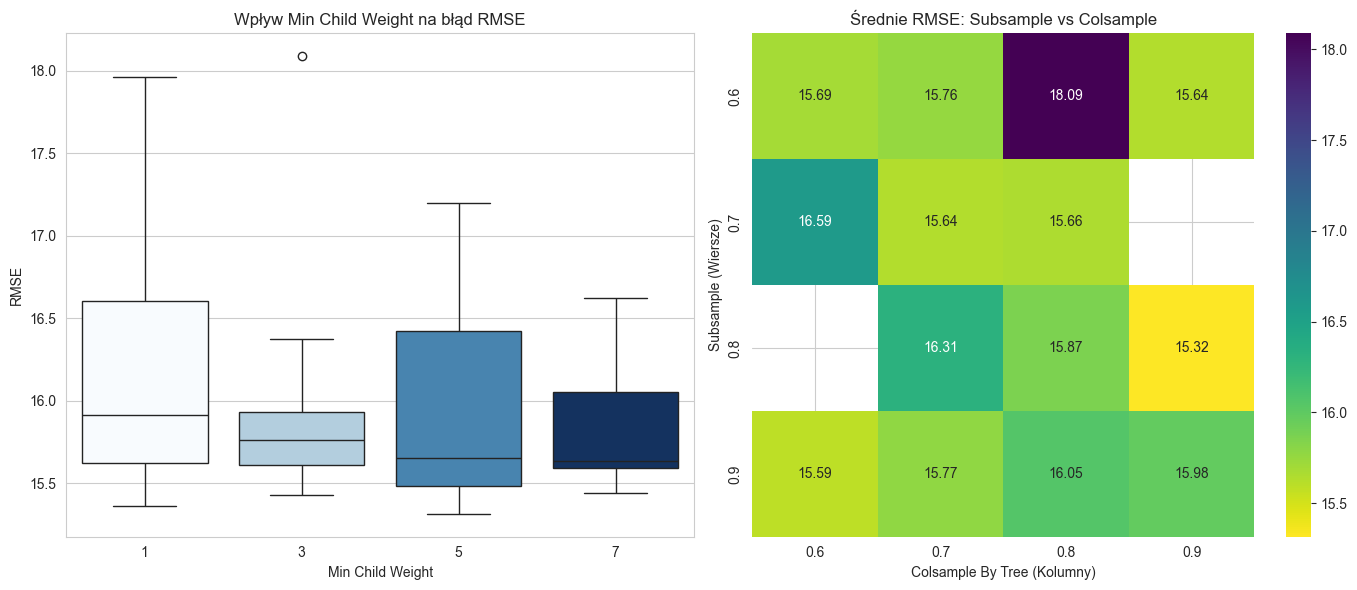

In [51]:
# Ustawienia wykresów
plt.figure(figsize=(14, 6))

# Wykres 3: Wpływ Min Child Weight (Konserwatyzm modelu)
# Czy model woli być ostrożny (duża waga) czy agresywny (mała waga)?
plt.subplot(1, 2, 1)
sns.boxplot(data=analysis_df, x='param_min_child_weight', y='RMSE', palette='Blues', hue='param_min_child_weight', legend=False)
plt.title('Wpływ Min Child Weight na błąd RMSE')
plt.xlabel('Min Child Weight')
plt.ylabel('RMSE')

# Wykres 4: Mapa Ciepła (Heatmap) dla losowości
# Jak współpracują ze sobą subsample i colsample?
pivot_table = analysis_df.pivot_table(
    values='RMSE',
    index='param_subsample',
    columns='param_colsample_bytree',
    aggfunc='mean'
)

plt.subplot(1, 2, 2)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis_r")
plt.title('Średnie RMSE: Subsample vs Colsample')
plt.xlabel('Colsample By Tree (Kolumny)')
plt.ylabel('Subsample (Wiersze)')

plt.tight_layout()
plt.show()

**Wnioski z analizy wpływu 'min_child_weight`, `subsample` oraz `colsample_bytree`**

1. Regularyzacja (`min_child_weight`)
    * Waga 1: Bardzo duży rozrzut wyników (długie wąsy). Model jest zbyt agresywny w tworzeniu liści.
    * Waga 3 (Optimum): Najniższa mediana i bardzo zwarta struktura pudełka.
    * Waga 5-7: Błąd zaczyna rosnąć – model staje się zbyt konserwatywny (zbyt trudno mu utworzyć nowy podział).

2. Losowość (`subsample` vs `colsample_bytree`)
    * Mapa ciepła wskazuje wyraźnego zwycięzcę z wynikiem RMSE = 15.32 (jasnożółte pole).
    * Najlepsza konfiguracja: `subsample` = 0.8 oraz `colsample_bytree` = 0.9.
    * Model najlepiej pracuje, gdy widzi 80% wierszy i 90% kolumn przy budowie każdego drzewa. Zbyt mała ilość danych (np. Subsample 0.6) drastycznie pogarsza wynik (fioletowe pole 18.09).

### 5. Walidacja optymalnych parametrów na zbiorze testowym
Sprawdźmy, czy parametry dobrane na walidacji krzyżowej (CV) faktycznie dają dobry wynik na zbiorze, którego model nigdy nie widział (Test Set).

In [27]:
# Wyświetlenie wylosowanych parametrów
print(random_search.best_params_)

# Pobranie najlepszego modelu z searchera
best_model = random_search.best_estimator_

# Predykcja na zbiorze testowym
y_pred = best_model.predict(X_test)


final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"WYNIKI NA ZBIORZE TESTOWYM")
print(f"RMSE: {final_rmse:.4f}")
print(f"R2:   {final_r2:.4f}")

{'subsample': 0.8, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.9}
WYNIKI NA ZBIORZE TESTOWYM
RMSE: 15.0792
R2:   0.4556


### 6. Manualne dostrajanie
Wylosowane parametry osiągają nieznacznie $R^2$ niższe niż domyślnie przyjęte w notatniku 3. Modeling.ipynb.

Sprawdźmy jakie rezultaty otrzymamy, gdy przyjmiemy następujące parametry:

* 'max_depth': 7
* 'n_estimators': 1200
* 'learning_rate': 0.1
* 'min_child_weight': 3
* 'gamma': 0.5
* 'colsample_bytree': 0.9
* 'subsample': 0.8

Następnie porównajmy jez parametrami przyjętymi w notatniku 3. Modeling.ipynb.

In [49]:
# Definicja parametrów manualnych
# parametry z fazy modelowania
modeling_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}

# parametry oparte na danych z tuningu
new_params = {
    'n_estimators': 1200,
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_child_weight': 3,
    'gamma': 0.5,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}


# Trenowanie modelu z parametrami z fazy modelowania
model_modeling_params = xgb.XGBRegressor(**modeling_params)
model_modeling_params.fit(X_train, y_train)

# Trenowanie modelu z nowo przyjętymi parametrami
model_new_params = xgb.XGBRegressor(**new_params)
model_new_params.fit(X_train, y_train)


# Predykcja na zbiorze testowym
y_pred_modeling = model_modeling_params.predict(X_test)
y_pred_new = model_new_params.predict(X_test)


# Ewaluacja
rmse_modeling = np.sqrt(mean_squared_error(y_test, y_pred_modeling))
r2_modeling = r2_score(y_test, y_pred_modeling)

rmse_new = np.sqrt(mean_squared_error(y_test, y_pred_new))
r2_new = r2_score(y_test, y_pred_new)

print(f"Wyniki predykcji - parametry z etapu modelowania: RMSE: {rmse_modeling:.4f}   R2: {r2_modeling:.4f}")
print(f"Wyniki predykcji - nowe parametry:                RMSE: {rmse_new:.4f}        R2: {r2_new:.4f}")
print(f"Wyniki predykcji - tuning automatyczny:           RMSE: {final_rmse:.4f}      R2: {final_r2:.4f}")

Wyniki predykcji - parametry z etapu modelowania: RMSE: 14.9026   R2: 0.4683
Wyniki predykcji - nowe parametry:                RMSE: 15.0382        R2: 0.4586
Wyniki predykcji - tuning automatyczny:           RMSE: 15.0792      R2: 0.4556


**Wnioski z analizy porównawczej i ocena procesu Tuningu**

Przeprowadzony eksperyment porównawczy wykazał, że przyjęte pierwotnie (domyślne) parametry pozwoliły uzyskać najlepsze wyniki.

Może się wydawać nieintuicyjne, że automat przegrał z "ręcznym" ustawieniem, ale jest to zjawisko w pełni wytłumaczalne technicznie:
* Parametry przyjęte w notatniku 3 (learning_rate=0.05, max_depth=8, subsample=0.8) to uniwersalne parametry dla zbiorów tej wielkości. Tuning startował więc z bardzo wysokiego pułapu, który trudno przebić bez bardzo precyzyjnego dostrajania.
* Ograniczona liczba prób (n_iter=30) wpłynęła na wynik tuningu. Przestrzeń hiperparametrów jest wielowymiarowa. Przy 6 parametrach liczba możliwych kombinacji idzie w tysiące. Wylosowanie zaledwie 30 punktów to jak szukanie igły w stogu siana przy użyciu 30 rzutów magnesem – statystycznie bardzo trudno trafić w idealną kombinację.
* Automat optymalizuje wynik na zbiorze walidacyjnym (średnia z 5 foldów). Czasami znajduje parametry, które dają optymalne wyniki, ale tracą zdolność generalizacji na zupełnie nowym zbiorze testowym. "Ręczny" model był bardziej konserwatywny, co opłaciło się na testach.

W tym przypadku zysk z tuningu okazał się ujemny. Wniosek - czyszczenie danych, inżynieria cech daje zazwyczaj lepsze rezultaty niż nieskończone kręcenie parametrami modelu.

Kierując się pragmatyzmem, odrzucam wyniki tuningu. Do finalnego pliku produkcyjnego main.py przyjmuje zestaw parametrów modeling_params, ponieważ oferuje on najlepszy balans między precyzją predykcji a zdolnością generalizacji.